In [1]:
import re
import nltk
#import wandb
import torch
import random
import string
import requests
import numpy as np
import pandas as pd
import contractions
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from tensorflow import keras
from textblob import TextBlob
from tqdm.notebook import tqdm
from keras import regularizers
from string import punctuation
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from keras.models import Sequential
from tqdm.keras import TqdmCallback
from transformers import BertTokenizer
from keras.utils import to_categorical
from transformers import EvalPrediction
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset
from transformers import TFDistilBertModel
from keras.layers import BatchNormalization
from transformers import DistilBertTokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from keras.preprocessing.text import Tokenizer
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from transformers import BertForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from transformers import AdamW, get_linear_schedule_with_warmup
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
from keras.layers import Input, Dense, Embedding, Dropout, Reshape, Flatten, LSTM, Bidirectional
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification


nltk.download('stopwords')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
train_df = pd.read_csv('/kaggle/input/new-train/train.csv')
test_df = pd.read_csv('/kaggle/input/new-test/test.csv')

In [5]:
train_df = train_df[['text', 'sentiment']]
test_df = test_df[['text', 'sentiment']]

replace from positive, neutral, positive to 2, 1, 0 in column sentiment

In [6]:
train_df['sentiment'] = train_df['sentiment'].replace(['positive','neutral','negative'], [2, 1, 0])
test_df['sentiment'] = test_df['sentiment'].replace(['positive','neutral','negative'], [2, 1, 0])

In [7]:
X_train, y_train = train_df['text'], train_df['sentiment']
X_test, y_test = test_df['text'], test_df['sentiment']

ratio of the sentiment

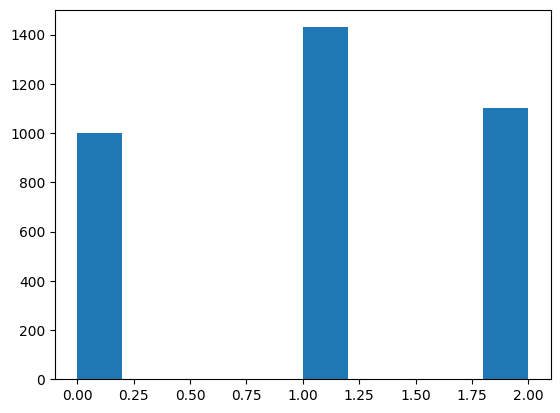

In [47]:
plt.hist(test_df['sentiment'])
plt.show()

In [8]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


Using pretrained model on English form HuggingFace

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

Preprocessing data

Full description in notebook FinalWork_v1

In [12]:
def text_cleaning(text):
    text = str(text).lower()
    text = ' '.join([elem for elem in text.split(' ') if elem.isalpha()])
    text = re.sub(re.compile(r'https?://\S+|www\.\S+'), '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in (stopwords.words('english') + ['ha', 'wa']))
    return text

def update_text(text):
    new_words = []
    flag = False
    text = contractions.fix(text)
    words = text.split()
    lem = WordNetLemmatizer()
    for word in words:
        if flag:
            word = 'not_' + word
            flag = False
        if word in ['not', 'no', 'never', "n't"]:
            flag = True
        else:
            new_words.append(lem.lemmatize(word))
    return ' '.join(new_words)

In [13]:
pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-tzg_58_h
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-tzg_58_h
  Resolved https://github.com/huggingface/accelerate to commit 9a86a49f72f5c9c0ca521b903fb1a44fa8ee8f53
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.20.0.dev0-py3-none-any.whl size=225635 sha256=d77280e05f0f84788ce92b92f5ff69d69cbd5740083f163c2c803ccde3e83aaa
  Stored in directory: /tmp/pip-ephem-wheel-cache-nj1vp97b/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.12.0
    Uninstalling accelerate-0.12.0:
      Successfully uninstalled accelerate-0.12.0
Note: you may need to restart the kernel to use updated packa

In [14]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

cleaning data for train and test df

In [16]:
train_df['text'] = train_df['text'].apply(lambda x: text_cleaning(x))
train_df['text'] = train_df['text'].apply(lambda x: update_text(x))
train_df['text'] = train_df['text'].apply(lambda x: remove_stopwords(x))   

In [17]:
test_df['text'] = test_df['text'].apply(lambda x: text_cleaning(x))
test_df['text'] = test_df['text'].apply(lambda x: update_text(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_stopwords(x))  

Using a tokenizer to encode a batch of texts for training and validation (and add some special tokens) 

* add_special_tokens = True - adding tokens such as CLS and SEP

* return_attention_mask = True - returns attention masks (indicates which tokens need to be attented and which ones need to be ignored)

* pad_to_max_length = True - all sequences will have the same length (max_length)

* return_tensors = 'pt'- format of returned tensors (PyTorch tensors)

In [18]:
train_texts = list(train_df.text)
test_texts = list(test_df.text)

encoded_data_train = tokenizer.batch_encode_plus(
    train_texts, add_special_tokens=True, return_attention_mask=True, 
    pad_to_max_length=True, max_length=512, return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    test_texts, add_special_tokens=True, return_attention_mask=True, 
    pad_to_max_length=True, max_length=512, return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.sentiment.values.tolist())

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(test_df.sentiment.values.tolist())

building datasets for working with tensors

In [20]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

creating custom dataset instead of previous one (alternative version)

In [21]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, unique_labels):
        self.encodings = encodings
        self.labels = labels
        self.unique_labels = unique_labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        labels = self.unique_labels * [0]
        labels[self.labels[idx]] = 1
        item["label"] = torch.tensor(labels).float()
        return item

    def __len__(self):
        return len(self.labels)

In [22]:
train_dataset = Dataset(encoded_data_train, labels_train, 3)
val_dataset = Dataset(encoded_data_val, labels_val, 3)

* num_train_epochs - number of training epochs

* per_device_train_batch_size - setting batch size for training, number of training examples which will processed parallel

* per_device_eval_batch_size - setting batch size for evaluation, number of evaluation examples which will processed parallel

* weight_decay - regularization technique to prevent overfitting

* load_best_model_at_end - best model according to the metrcis will be saved at the end of the training

* learning_rate - learning rate, which controls step size during training

* evaluation_strategy - model will be evaluated at the end of epoch

* save_strategy - model will be saved at the end of the epoch

* seed - To ensure reproducibility we can set the random seed of this parameter. Using seeds for random processes during model training guarantees determinism and reproducibility

In [23]:
training_args = TrainingArguments(
    output_dir='./results_pred', num_train_epochs=3,
    per_device_train_batch_size=8, per_device_eval_batch_size=5,
    weight_decay=0.01,
    load_best_model_at_end=True, 
    learning_rate=5e-5,
    evaluation_strategy='epoch', save_strategy='epoch',
    save_total_limit=1,
    seed=21
)

using well writen function of metrics from source

In [24]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [36]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=3,
                                                      problem_type="multi_label_classification",
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [26]:
trainer = Trainer(
    model=model, tokenizer=tokenizer, train_dataset=train_dataset,
    eval_dataset=val_dataset, args=training_args,
    compute_metrics=compute_metrics
)          

****************d1a1196c3912141e779fb72c320e9c31a5dc28a3

In [27]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/tmp/ipykernel_31/3976564599.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.443300,0.417762,0.702695,0.776104,0.678834
2,0.377600,0.425357,0.710221,0.781834,0.691285
3,0.279600,0.493336,0.699841,0.774406,0.685625


/tmp/ipykernel_31/3976564599.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/tmp/ipykernel_31/3976564599.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension

TrainOutput(global_step=5154, training_loss=0.37599469156379983, metrics={'train_runtime': 4590.4787, 'train_samples_per_second': 17.96, 'train_steps_per_second': 1.123, 'total_flos': 2.1691859497749504e+16, 'train_loss': 0.37599469156379983, 'epoch': 3.0})

In order to get accuracy per class (positive, neutral, negative) it is needed to find prediction

In [56]:
def get_prediction_from_trainer():
    test_prediction = trainer.predict(val_dataset)
    labels = np.argmax(test_prediction.predictions, axis = -1)
    return labels

In [57]:
pred = get_prediction_from_trainer()
print(pred)

/tmp/ipykernel_31/3976564599.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


[1 2 0 ... 1 2 2]


function accuracy_per_class computes and prints the accuracy per class and overall accuracy based on the provided predictions and true values

In [ ]:
def accuracy_per_class(predictions, true_vals):
    label_dict = {0: 'Class 0', 1: 'Class 1', 2: 'Class 2'}
    class_counts = {label: {'correct': 0, 'total': 0} for label in label_dict.values()}

    for pred, true in zip(predictions, true_vals):
        pred_label, true_label = label_dict[pred], label_dict[true]
        class_counts[pred_label]['total'] += 1
        if pred_label == true_label:
            class_counts[pred_label]['correct'] += 1

    for label, counts in class_counts.items():
        accuracy = counts['correct'] / counts['total']
        print(f"Class: {label}")
        print(f"Accuracy: {counts['correct']} / {counts['total']} = {accuracy:.4f}\n")

    overall_accuracy = accuracy_score(true_vals, predictions)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")


In [62]:
accuracy_per_class(pred, y_test)

Class: Class 0
Accuracy: 668 / 919 = 0.7269

Class: Class 1
Accuracy: 1070 / 1660 = 0.6446

Class: Class 2
Accuracy: 772 / 955 = 0.8084

Overall Accuracy: 0.7102


You can see that the accuracy of the model exceeds the previous algorithm in notebook FinalWork_v1. We obtained: 71% accuracy.

In [28]:
trainer.evaluate()

/tmp/ipykernel_31/3976564599.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.41776183247566223,
 'eval_f1': 0.7026947861745753,
 'eval_roc_auc': 0.7761035653650256,
 'eval_accuracy': 0.678834182229768,
 'eval_runtime': 74.1021,
 'eval_samples_per_second': 47.691,
 'eval_steps_per_second': 4.777,
 'epoch': 3.0}